In [15]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import wandb
import tqdm.notebook as tqdm


## cuda check

In [16]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
display(train_on_gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True

## Load CIFAR10 dataset

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

## WandB login

In [18]:
wandb.login()

True

## EDA

In [19]:
#TODO

# overfitting a single batch

In [20]:
#get one batch of data but in the same label for easier overfitting
overfit_label = 1
num_samples = 1

images_same_label = []

for img, label in trainset:
    if label == overfit_label:
        images_same_label.append(img)
    if len(images_same_label) == num_samples:
        break
        
images_overfit = torch.stack(images_same_label)

images_overfit.shape

torch.Size([1, 3, 32, 32])

## forward process (Noise sheduler)

In [21]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Create a linear beta schedule for the diffusion model.
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension. (helperfunction)
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod,device="gpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

def precompute_terms(betas):
    """
    Precomputes terms required to calculate the noisy version of an image
    """
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    return {
        "alphas": alphas,
        "alphas_cumprod": alphas_cumprod,
        "alphas_cumprod_prev": alphas_cumprod_prev,
        "sqrt_recip_alphas": sqrt_recip_alphas,
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,
        "posterior_variance": posterior_variance
    }

In [22]:
T = 100
betas = linear_beta_schedule(timesteps=T)
terms = precompute_terms(betas)

In [23]:
# visualise the simulated forward diffusion
num_images = 10
stepsize = int(T/num_images)


# TODO:try to do visualisation
# fig, axes = plt.subplots(1, num_images, figsize=(20, 20))

# for i in range(num_images):
#     t = stepsize * i
#     noisy_image, _ = forward_diffusion_sample(images_overfit, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"])
#     img = noisy_image[0].permute(1, 2, 0).detach().cpu().numpy() 
#     img = (img * 0.5) + 0.5   # from [-1,1] to [0,1]
#     img = np.clip(img, 0, 1)
#     axes[i].imshow(img)
#     axes[i].axis('off')
#     axes[i].set_title(f"t = {t}")
#     
# plt.show()

##Simple Diffusion

In [24]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
            
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)
    
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

In [25]:
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [26]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

## Loss function

In [27]:
def get_loss(model, x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device):
    x_noisy, noise = forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 5000
BATCH_SIZE = 1
T = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
    loss = get_loss(model, images_overfit, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"], device)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")
        

Epoch 0 | step 000 Loss: 0.23021142184734344 
Epoch 5 | step 000 Loss: 0.20368216931819916 
Epoch 10 | step 000 Loss: 0.20320603251457214 
Epoch 15 | step 000 Loss: 0.18287229537963867 
Epoch 20 | step 000 Loss: 0.209351047873497 
Epoch 25 | step 000 Loss: 0.25937187671661377 
Epoch 30 | step 000 Loss: 0.19205191731452942 
Epoch 35 | step 000 Loss: 0.1908656358718872 
Epoch 40 | step 000 Loss: 0.20560261607170105 
Epoch 45 | step 000 Loss: 0.18963488936424255 
Epoch 50 | step 000 Loss: 0.3671433925628662 
Epoch 55 | step 000 Loss: 0.20395927131175995 
Epoch 60 | step 000 Loss: 0.315218985080719 
Epoch 65 | step 000 Loss: 0.18640261888504028 
Epoch 70 | step 000 Loss: 0.1890612095594406 
Epoch 75 | step 000 Loss: 0.19320683181285858 
Epoch 80 | step 000 Loss: 0.18388333916664124 
Epoch 85 | step 000 Loss: 0.17314457893371582 
Epoch 90 | step 000 Loss: 0.1834353655576706 
Epoch 95 | step 000 Loss: 0.17706458270549774 
Epoch 100 | step 000 Loss: 0.19486817717552185 
Epoch 105 | step 000 L

In [53]:
images_overfit.shape

torch.Size([1, 3, 32, 32])

In [1]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Downsampling layers
        self.enc1 = (
            nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        # Upsampling path with skip connections
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
            # Encoder
            x1 = self.enc1(x)
            x2 = self.enc2(F.max_pool2d(x1, 2))
            x3 = self.enc3(F.max_pool2d(x2, 2))
    
            # Decoder with skip connections
            x = F.interpolate(self.dec3(x3), scale_factor=2, mode='nearest') + x2
            x = F.interpolate(self.dec2(x), scale_factor=2, mode='nearest') + x1
            x = self.dec1(x)
            return x

NameError: name 'nn' is not defined

In [8]:
## Define the diffusion process
class DiffusionModel(nn.Module):
    def __init__(self, model, timesteps=1000):
        super(DiffusionModel, self).__init__()
        self.model = model
        self.timesteps = timesteps
        self.beta = torch.linspace(0.0001, 0.02, timesteps)  # Linear schedule
        self.alpha = 1 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    def forward_diffusion(self, x0, t):
        """Apply forward diffusion to add noise to the images."""
        noise = torch.randn_like(x0)
        sqrt_alpha_cumprod_t = torch.sqrt(self.alpha_cumprod[t]).view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - self.alpha_cumprod[t]).view(-1, 1, 1, 1)
        return sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise, noise

    def sample(self, x, t):
        """Reverse process: denoise the image step-by-step."""
        for i in reversed(range(t)):
            z = torch.randn_like(x) if i > 0 else 0  # No noise at last step
            x = (1 / torch.sqrt(self.alpha[i])) * (
                x - (1 - self.alpha[i]) / torch.sqrt(1 - self.alpha_cumprod[i]) * self.model(x)
            ) + torch.sqrt(self.beta[i]) * z
        return x

In [11]:
wandb.init(project="diffusion_overfittest", name= "test", entity="floowbaumgartner")

## Training the model
unet = UNet()
diffusion_model = DiffusionModel(unet)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
diffusion_model.to(device)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-4)

# Loss function tuning
for epoch in range(10_000):
    images = images_overfit.to(device)
    t = torch.randint(0, diffusion_model.timesteps, (images.size(0),), device=device)
    noisy_images, noise = diffusion_model.forward_diffusion(images, t)

    # Predict the noise
    predicted_noise = unet(noisy_images)
    loss = F.mse_loss(predicted_noise, noise)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    wandb.log({"epoch": epoch + 1, "loss": loss.item()})
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
loss,█▇▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁
epoch,1000
loss,0.28878


Epoch 1, Loss: 1.4546468257904053
Epoch 2, Loss: 1.4374148845672607
Epoch 3, Loss: 1.5342620611190796
Epoch 4, Loss: 1.4501079320907593
Epoch 5, Loss: 1.4262975454330444
Epoch 6, Loss: 1.5022828578948975
Epoch 7, Loss: 1.5231155157089233
Epoch 8, Loss: 1.5189450979232788
Epoch 9, Loss: 1.4374494552612305
Epoch 10, Loss: 1.3791780471801758
Epoch 11, Loss: 1.3227753639221191
Epoch 12, Loss: 1.4845962524414062
Epoch 13, Loss: 1.359010100364685
Epoch 14, Loss: 1.289569616317749
Epoch 15, Loss: 1.3511407375335693
Epoch 16, Loss: 1.3516511917114258
Epoch 17, Loss: 1.3087003231048584
Epoch 18, Loss: 1.3078935146331787
Epoch 19, Loss: 1.3211406469345093
Epoch 20, Loss: 1.2248848676681519
Epoch 21, Loss: 1.2639081478118896
Epoch 22, Loss: 1.2716107368469238
Epoch 23, Loss: 1.2349979877471924
Epoch 24, Loss: 1.2172902822494507
Epoch 25, Loss: 1.2265385389328003
Epoch 26, Loss: 1.2059054374694824
Epoch 27, Loss: 1.1348645687103271
Epoch 28, Loss: 1.2524662017822266
Epoch 29, Loss: 1.1563973426818

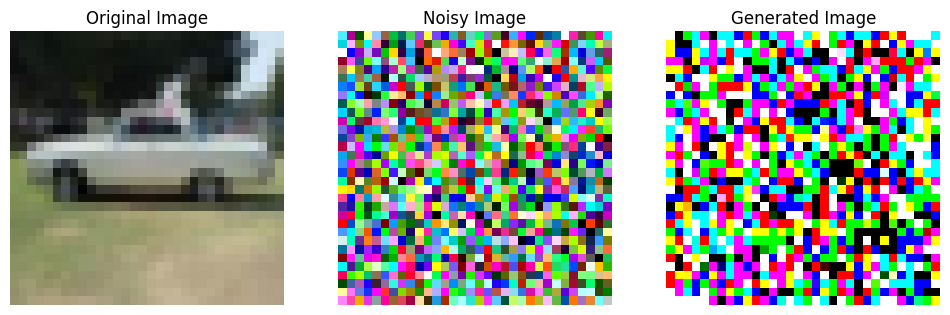

In [10]:
## Testing and Inference
# Test the forward diffusion process on a single image
sample_image, _ = next(iter(trainloader))
sample_image = sample_image[0].unsqueeze(0).to(device)

# Forward diffusion
timestep = diffusion_model.timesteps - 1
noisy_image, _ = diffusion_model.forward_diffusion(sample_image, timestep)

# Reverse process to generate image
generated_image = diffusion_model.sample(noisy_image, diffusion_model.timesteps)


def show_images(original, noisy, generated):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Denormalize and detach tensors for visualization
    original = original.cpu().squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5
    noisy = noisy.cpu().squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5
    generated = generated.cpu().squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5

    # Clip values to [0, 1] for imshow
    original = np.clip(original, 0, 1)
    noisy = np.clip(noisy, 0, 1)
    generated = np.clip(generated, 0, 1)

    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(noisy)
    axes[1].set_title('Noisy Image')
    axes[1].axis('off')

    axes[2].imshow(generated)
    axes[2].set_title('Generated Image')
    axes[2].axis('off')

    plt.show()

show_images(sample_image, noisy_image, generated_image)